# Scenario X Config -> score training with Random Forest Regression

In [1]:
# import os 
# os.environ["MODIN_ENGINE"] = "ray"
# import modin.pandas as modin_pd

# import dask.dataframe as dd

import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from ad_config_search.utils import get_rows
RSEED = 50

%load_ext autoreload
%autoreload 2

## Load tables and clean data

In [2]:
# Load in data
with open("df_configs_5sectors.pl", 'rb') as f:
    config_df = pickle.load(f)
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,metric
0,training_0000-S23-P0_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,30.547550,T_mota
1,training_0000-S23-P1_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,39.197930,T_mota
2,training_0000-S23-P2_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,37.049861,T_mota
3,training_0000-S23-P3_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,28.266494,T_mota
4,training_0000-S23-P4_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,29.371688,T_mota
...,...,...,...,...,...,...,...,...,...,...
1704955,training_0003-S1-P0_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-9.959350,T_mota
1704956,training_0003-S1-P1_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-3.034682,T_mota
1704957,training_0003-S1-P2_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-10.264901,T_mota
1704958,training_0003-S1-P3_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-27.734375,T_mota


In [3]:
config_df = config_df[config_df["D-seq-pol"] != "infinite"]  # filter out infinite runs
config_df["D-conf"] = config_df["D-conf"].astype(float)
config_df["T-min-iou"] = config_df["T-min-iou"].astype(float)
config_df["T-max-age"] = config_df["T-max-age"].astype(int)
config_df["T-every-nth-det"] = config_df["T-every-nth-det"].astype(int)
config_df = config_df.drop(columns=["metric"])
config_df["score"] = config_df["score"].astype(float)
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
0,training_0000-S23-P0_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,30.547550
1,training_0000-S23-P1_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,39.197930
2,training_0000-S23-P2_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,37.049861
3,training_0000-S23-P3_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,28.266494
4,training_0000-S23-P4_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,29.371688
...,...,...,...,...,...,...,...,...,...
1704955,training_0003-S1-P0_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-9.959350
1704956,training_0003-S1-P1_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-3.034682
1704957,training_0003-S1-P2_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-10.264901
1704958,training_0003-S1-P3_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-27.734375


In [4]:
with open("oracle_k_10_policy.pl", 'rb') as f:
    oracle_k_10_policy = pickle.load(f)
import json
oracle_k_10_configs = [json.loads(s) for s in np.unique([json.dumps(c) for c in oracle_k_10_policy.values()])]
len(oracle_k_10_configs)

50

In [5]:
config_df = pd.concat([get_rows(config_df, c) for c in tqdm(oracle_k_10_configs)])

100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


In [6]:
print(np.sum(np.isnan(config_df["score"])))
print(np.sum(np.isinf(config_df["score"])))
config_df = config_df[config_df["score"].notna()]
config_df = config_df[~config_df["score"].isin([-np.inf])]
print(np.sum(np.isnan(config_df["score"])))
print(np.sum(np.isinf(config_df["score"])))

337
213
0
0


In [7]:
# 148 scenarios * 50 configs * 5 sections in scenario = 37000
# 37000 - 337 - 213 = 36450
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
11450,training_0000-S0-P0_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,25.555556
11451,training_0000-S0-P1_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,24.814815
11452,training_0000-S0-P2_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,29.366603
11453,training_0000-S0-P3_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,35.036496
11454,training_0000-S0-P4_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,33.243968
...,...,...,...,...,...,...,...,...,...
1694479,training_0001-S20-P4_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,71.008403
1704780,training_0002-S21-P0_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,0.000000
1704781,training_0002-S21-P1_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,-4.761905
1704782,training_0002-S21-P2_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,-57.142857


In [17]:
scenario_feats_df = pd.read_parquet("past_features_from_pipeline_4s_chunks.pq")
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,avg_bbox_size,90p_bbox_size,10p_bbox_size,avg_bbox_speed,...,time_of_day,weather,location,scenario_name,pastC-D-model,pastC-D-conf,pastC-D-seq-pol,pastC-T-min-iou,pastC-T-max-age,pastC-T-every-nth-det
0,9.583333,14.5,4.0,2.875,5.0,0.0,195177.031863,294325.400000,128192.240000,172.191762,...,Day,sunny,location_sf,training_0000-S20-P1_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
1,13.176471,31.0,1.0,5.600,7.0,5.0,63057.921310,108681.900000,39316.892857,65.749491,...,Day,sunny,location_sf,training_0000-S20-P2_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
2,25.181818,40.0,9.0,6.925,8.1,5.0,58437.529345,73279.713889,49661.671429,43.374975,...,Day,sunny,location_sf,training_0000-S20-P3_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
3,18.950000,40.0,4.9,9.475,11.0,8.0,58399.155960,84967.600000,34437.420000,49.116288,...,Day,sunny,location_sf,training_0000-S20-P4_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
5,10.709677,32.0,3.0,8.300,11.1,7.0,34198.702249,56752.050549,18958.728571,68.021982,...,Night,sunny,location_sf,training_0000-S7-P1_5,efficientdet-d3,0.3,eager,0.5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156268,9.301587,22.0,3.0,14.650,17.0,12.0,32156.486782,42864.076923,24362.666667,11.674608,...,Dawn/Dusk,sunny,location_sf,training_0002-S17-P4_5,efficientdet-d5,0.3,wait,0.3,5,5
2156270,3.086957,3.0,3.0,1.775,5.0,0.0,6435.890385,10262.200000,4314.750000,14.080128,...,Day,sunny,location_other,training_0003-S1-P1_5,efficientdet-d6,0.3,eager,0.5,3,3
2156271,3.526316,6.0,3.0,1.675,3.0,1.0,4925.621622,6968.000000,3979.500000,53.155989,...,Day,sunny,location_other,training_0003-S1-P2_5,efficientdet-d6,0.3,eager,0.5,3,3
2156272,3.216216,3.0,1.0,2.975,4.1,1.0,6138.419167,15744.000000,2292.525000,24.860260,...,Day,sunny,location_other,training_0003-S1-P3_5,efficientdet-d6,0.3,eager,0.5,3,3


In [18]:
scenario_feats_df.columns

Index(['avg_bbox_longevity', '90p_bbox_longevity', '10p_bbox_longevity',
       'avg_num_bboxes', '90p_num_bboxes', '10p_num_bboxes', 'avg_bbox_size',
       '90p_bbox_size', '10p_bbox_size', 'avg_bbox_speed', '90p_bbox_speed',
       '10p_bbox_speed', 'avg_ego_speed', '90p_ego_speed', '10p_ego_speed',
       'time_of_day', 'weather', 'location', 'scenario_name', 'pastC-D-model',
       'pastC-D-conf', 'pastC-D-seq-pol', 'pastC-T-min-iou', 'pastC-T-max-age',
       'pastC-T-every-nth-det'],
      dtype='object')

In [19]:
scenario_feats_df = scenario_feats_df.drop(columns=["weather"])  # weather column is all the same
scenario_feats_df = scenario_feats_df[scenario_feats_df["pastC-D-seq-pol"] != "infinite"]  # filter out infinite runs
scenario_feats_df["pastC-D-conf"] = scenario_feats_df["pastC-D-conf"].astype(float)
scenario_feats_df["pastC-T-min-iou"] = scenario_feats_df["pastC-T-min-iou"].astype(float)
scenario_feats_df["pastC-T-max-age"] = scenario_feats_df["pastC-T-max-age"].astype(int)
scenario_feats_df["pastC-T-every-nth-det"] = scenario_feats_df["pastC-T-every-nth-det"].astype(int)
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,avg_bbox_size,90p_bbox_size,10p_bbox_size,avg_bbox_speed,...,10p_ego_speed,time_of_day,location,scenario_name,pastC-D-model,pastC-D-conf,pastC-D-seq-pol,pastC-T-min-iou,pastC-T-max-age,pastC-T-every-nth-det
0,9.583333,14.5,4.0,2.875,5.0,0.0,195177.031863,294325.400000,128192.240000,172.191762,...,0.553284,Day,location_sf,training_0000-S20-P1_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
1,13.176471,31.0,1.0,5.600,7.0,5.0,63057.921310,108681.900000,39316.892857,65.749491,...,1.655318,Day,location_sf,training_0000-S20-P2_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
2,25.181818,40.0,9.0,6.925,8.1,5.0,58437.529345,73279.713889,49661.671429,43.374975,...,2.651415,Day,location_sf,training_0000-S20-P3_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
3,18.950000,40.0,4.9,9.475,11.0,8.0,58399.155960,84967.600000,34437.420000,49.116288,...,3.408815,Day,location_sf,training_0000-S20-P4_5,efficientdet-d1,0.3,tail-aware,0.2,1,5
5,10.709677,32.0,3.0,8.300,11.1,7.0,34198.702249,56752.050549,18958.728571,68.021982,...,3.297056,Night,location_sf,training_0000-S7-P1_5,efficientdet-d3,0.3,eager,0.5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156268,9.301587,22.0,3.0,14.650,17.0,12.0,32156.486782,42864.076923,24362.666667,11.674608,...,0.000000,Dawn/Dusk,location_sf,training_0002-S17-P4_5,efficientdet-d5,0.3,wait,0.3,5,5
2156270,3.086957,3.0,3.0,1.775,5.0,0.0,6435.890385,10262.200000,4314.750000,14.080128,...,2.940277,Day,location_other,training_0003-S1-P1_5,efficientdet-d6,0.3,eager,0.5,3,3
2156271,3.526316,6.0,3.0,1.675,3.0,1.0,4925.621622,6968.000000,3979.500000,53.155989,...,9.254349,Day,location_other,training_0003-S1-P2_5,efficientdet-d6,0.3,eager,0.5,3,3
2156272,3.216216,3.0,1.0,2.975,4.1,1.0,6138.419167,15744.000000,2292.525000,24.860260,...,11.739923,Day,location_other,training_0003-S1-P3_5,efficientdet-d6,0.3,eager,0.5,3,3


In [20]:
scenario_feats_df = pd.concat([get_rows(scenario_feats_df, {"pastC-{}".format(k): v for k, v in c.items()}) for c in tqdm(oracle_k_10_configs)])


100%|██████████| 50/50 [00:01<00:00, 49.08it/s]


In [22]:
# The number of rows is expected to be 148 scenarios * 50 configurations * 4 sections (not 5, the first one is excluded) = 29600 rows.
# Because we don't log the config used to generate the jsonl file, we relied instead on the name of the csv file in the same directory, assuming that they are the same.
# There were 11599 jsonl files with more, or less, than 1 csv file in their directory. Because of this ambiguity we excluded those jsonl files.
# One point of worry is that assuming uniform loss we'd expect 50/2304 * 11599 = 251.714409722 rows to have been missing, but instead we see 29600 - 28080 = 1520 missing instead, which is 6x more.
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,avg_bbox_size,90p_bbox_size,10p_bbox_size,avg_bbox_speed,...,10p_ego_speed,time_of_day,location,scenario_name,pastC-D-model,pastC-D-conf,pastC-D-seq-pol,pastC-T-min-iou,pastC-T-max-age,pastC-T-every-nth-det
345,15.500000,35.1,3.0,4.650,6.0,2.7,50041.172685,90532.900000,18663.833333,73.847009,...,3.297056,Night,location_sf,training_0000-S7-P1_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
346,14.200000,33.4,3.0,5.325,7.0,4.0,29741.855685,45636.753333,20554.575000,79.806441,...,7.051953,Night,location_sf,training_0000-S7-P2_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
347,11.428571,19.4,2.0,4.000,6.0,3.0,48599.677857,82858.540000,24015.466667,97.323104,...,6.179338,Night,location_sf,training_0000-S7-P3_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
348,10.214286,29.1,3.0,3.575,5.0,2.0,13677.467917,16776.550000,9677.200000,19.038599,...,1.236840,Night,location_sf,training_0000-S7-P4_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
2660,20.000000,36.0,3.0,3.000,4.0,2.7,28621.381944,31729.166667,23966.750000,8.787503,...,17.270621,Day,location_phx,training_0000-S2-P1_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143143,20.120000,40.0,2.0,12.575,13.0,11.0,27860.409197,40478.123077,13894.236364,74.277206,...,3.954529,Day,location_sf,training_0001-S20-P4_5,efficientdet-d7x,0.5,wait,0.2,3,1
2156085,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,11.164614,Day,location_phx,training_0002-S21-P1_5,efficientdet-d7x,0.5,wait,0.2,3,1
2156086,1.750000,2.0,1.3,0.175,1.0,0.0,5425.000000,15385.000000,988.000000,0.000000,...,10.842892,Day,location_phx,training_0002-S21-P2_5,efficientdet-d7x,0.5,wait,0.2,3,1
2156087,3.000000,3.0,3.0,0.075,0.0,0.0,2113.000000,2652.000000,1651.200000,0.000000,...,7.357362,Day,location_phx,training_0002-S21-P3_5,efficientdet-d7x,0.5,wait,0.2,3,1


In [21]:
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,avg_bbox_size,90p_bbox_size,10p_bbox_size,avg_bbox_speed,...,10p_ego_speed,time_of_day,location,scenario_name,pastC-D-model,pastC-D-conf,pastC-D-seq-pol,pastC-T-min-iou,pastC-T-max-age,pastC-T-every-nth-det
345,15.500000,35.1,3.0,4.650,6.0,2.7,50041.172685,90532.900000,18663.833333,73.847009,...,3.297056,Night,location_sf,training_0000-S7-P1_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
346,14.200000,33.4,3.0,5.325,7.0,4.0,29741.855685,45636.753333,20554.575000,79.806441,...,7.051953,Night,location_sf,training_0000-S7-P2_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
347,11.428571,19.4,2.0,4.000,6.0,3.0,48599.677857,82858.540000,24015.466667,97.323104,...,6.179338,Night,location_sf,training_0000-S7-P3_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
348,10.214286,29.1,3.0,3.575,5.0,2.0,13677.467917,16776.550000,9677.200000,19.038599,...,1.236840,Night,location_sf,training_0000-S7-P4_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
2660,20.000000,36.0,3.0,3.000,4.0,2.7,28621.381944,31729.166667,23966.750000,8.787503,...,17.270621,Day,location_phx,training_0000-S2-P1_5,efficientdet-d1,0.3,tail-aware,0.1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143143,20.120000,40.0,2.0,12.575,13.0,11.0,27860.409197,40478.123077,13894.236364,74.277206,...,3.954529,Day,location_sf,training_0001-S20-P4_5,efficientdet-d7x,0.5,wait,0.2,3,1
2156085,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,11.164614,Day,location_phx,training_0002-S21-P1_5,efficientdet-d7x,0.5,wait,0.2,3,1
2156086,1.750000,2.0,1.3,0.175,1.0,0.0,5425.000000,15385.000000,988.000000,0.000000,...,10.842892,Day,location_phx,training_0002-S21-P2_5,efficientdet-d7x,0.5,wait,0.2,3,1
2156087,3.000000,3.0,3.0,0.075,0.0,0.0,2113.000000,2652.000000,1651.200000,0.000000,...,7.357362,Day,location_phx,training_0002-S21-P3_5,efficientdet-d7x,0.5,wait,0.2,3,1


In [23]:
scenario_feats_df = scenario_feats_df.drop(columns=[col for col in scenario_feats_df.columns if col.startswith("pastC-")])  # Remove past configuration used to create environment to become agnostic to it
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,avg_bbox_size,90p_bbox_size,10p_bbox_size,avg_bbox_speed,90p_bbox_speed,10p_bbox_speed,avg_ego_speed,90p_ego_speed,10p_ego_speed,time_of_day,location,scenario_name
345,15.500000,35.1,3.0,4.650,6.0,2.7,50041.172685,90532.900000,18663.833333,73.847009,105.581585,51.057002,4.229544,5.741853,3.297056,Night,location_sf,training_0000-S7-P1_5
346,14.200000,33.4,3.0,5.325,7.0,4.0,29741.855685,45636.753333,20554.575000,79.806441,102.162948,58.838826,8.100904,8.656415,7.051953,Night,location_sf,training_0000-S7-P2_5
347,11.428571,19.4,2.0,4.000,6.0,3.0,48599.677857,82858.540000,24015.466667,97.323104,153.437238,41.622417,7.208279,8.046552,6.179338,Night,location_sf,training_0000-S7-P3_5
348,10.214286,29.1,3.0,3.575,5.0,2.0,13677.467917,16776.550000,9677.200000,19.038599,22.290174,11.743873,3.127603,5.103297,1.236840,Night,location_sf,training_0000-S7-P4_5
2660,20.000000,36.0,3.0,3.000,4.0,2.7,28621.381944,31729.166667,23966.750000,8.787503,14.781833,4.126557,17.761927,18.228929,17.270621,Day,location_phx,training_0000-S2-P1_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143143,20.120000,40.0,2.0,12.575,13.0,11.0,27860.409197,40478.123077,13894.236364,74.277206,105.661092,37.656822,4.878921,5.669946,3.954529,Day,location_sf,training_0001-S20-P4_5
2156085,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.192055,11.208892,11.164614,Day,location_phx,training_0002-S21-P1_5
2156086,1.750000,2.0,1.3,0.175,1.0,0.0,5425.000000,15385.000000,988.000000,0.000000,0.000000,0.000000,11.083378,11.212446,10.842892,Day,location_phx,training_0002-S21-P2_5
2156087,3.000000,3.0,3.0,0.075,0.0,0.0,2113.000000,2652.000000,1651.200000,0.000000,0.000000,0.000000,8.858669,10.277244,7.357362,Day,location_phx,training_0002-S21-P3_5


In [24]:
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,avg_bbox_size,90p_bbox_size,10p_bbox_size,avg_bbox_speed,90p_bbox_speed,10p_bbox_speed,avg_ego_speed,90p_ego_speed,10p_ego_speed,time_of_day,location,scenario_name
345,15.500000,35.1,3.0,4.650,6.0,2.7,50041.172685,90532.900000,18663.833333,73.847009,105.581585,51.057002,4.229544,5.741853,3.297056,Night,location_sf,training_0000-S7-P1_5
346,14.200000,33.4,3.0,5.325,7.0,4.0,29741.855685,45636.753333,20554.575000,79.806441,102.162948,58.838826,8.100904,8.656415,7.051953,Night,location_sf,training_0000-S7-P2_5
347,11.428571,19.4,2.0,4.000,6.0,3.0,48599.677857,82858.540000,24015.466667,97.323104,153.437238,41.622417,7.208279,8.046552,6.179338,Night,location_sf,training_0000-S7-P3_5
348,10.214286,29.1,3.0,3.575,5.0,2.0,13677.467917,16776.550000,9677.200000,19.038599,22.290174,11.743873,3.127603,5.103297,1.236840,Night,location_sf,training_0000-S7-P4_5
2660,20.000000,36.0,3.0,3.000,4.0,2.7,28621.381944,31729.166667,23966.750000,8.787503,14.781833,4.126557,17.761927,18.228929,17.270621,Day,location_phx,training_0000-S2-P1_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143143,20.120000,40.0,2.0,12.575,13.0,11.0,27860.409197,40478.123077,13894.236364,74.277206,105.661092,37.656822,4.878921,5.669946,3.954529,Day,location_sf,training_0001-S20-P4_5
2156085,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.192055,11.208892,11.164614,Day,location_phx,training_0002-S21-P1_5
2156086,1.750000,2.0,1.3,0.175,1.0,0.0,5425.000000,15385.000000,988.000000,0.000000,0.000000,0.000000,11.083378,11.212446,10.842892,Day,location_phx,training_0002-S21-P2_5
2156087,3.000000,3.0,3.0,0.075,0.0,0.0,2113.000000,2652.000000,1651.200000,0.000000,0.000000,0.000000,8.858669,10.277244,7.357362,Day,location_phx,training_0002-S21-P3_5


### Join tables, one-hot encode

In [25]:
# scenario_feats_df misses all -P0_5 scenarios
# config_df misses one scenario with nans or -infs in it
x = set(config_df["run"])
y = set(scenario_feats_df["scenario_name"])
x.difference(y), y.difference(x)

({'training_0000-S0-P0_5',
  'training_0000-S1-P0_5',
  'training_0000-S10-P0_5',
  'training_0000-S11-P0_5',
  'training_0000-S12-P0_5',
  'training_0000-S13-P0_5',
  'training_0000-S14-P0_5',
  'training_0000-S15-P0_5',
  'training_0000-S16-P0_5',
  'training_0000-S17-P0_5',
  'training_0000-S18-P0_5',
  'training_0000-S19-P0_5',
  'training_0000-S2-P0_5',
  'training_0000-S20-P0_5',
  'training_0000-S21-P0_5',
  'training_0000-S22-P0_5',
  'training_0000-S23-P0_5',
  'training_0000-S3-P0_5',
  'training_0000-S4-P0_5',
  'training_0000-S5-P0_5',
  'training_0000-S6-P0_5',
  'training_0000-S7-P0_5',
  'training_0000-S8-P0_5',
  'training_0000-S9-P0_5',
  'training_0001-S0-P0_5',
  'training_0001-S1-P0_5',
  'training_0001-S10-P0_5',
  'training_0001-S11-P0_5',
  'training_0001-S12-P0_5',
  'training_0001-S13-P0_5',
  'training_0001-S14-P0_5',
  'training_0001-S15-P0_5',
  'training_0001-S16-P0_5',
  'training_0001-S17-P0_5',
  'training_0001-S18-P0_5',
  'training_0001-S19-P0_5',
  't

In [26]:
joined_df = config_df.set_index('run').join(scenario_feats_df.set_index('scenario_name'), lsuffix="_config_df", rsuffix="_scenario_df", how="inner")
# assert not joined_df.isnull().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
# assert not joined_df.isna().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
joined_df

,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,...,90p_bbox_size,10p_bbox_size,avg_bbox_speed,90p_bbox_speed,10p_bbox_speed,avg_ego_speed,90p_ego_speed,10p_ego_speed,time_of_day,location
training_0000-S0-P1_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,24.814815,18.750000,30.6,...,128711.500000,48553.750000,108.285083,169.288216,63.935257,5.517220,5.980382,5.009959,Day,location_sf
training_0000-S0-P1_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,24.814815,14.000000,29.0,...,123017.400000,49215.550000,104.601120,143.287480,65.787625,5.517220,5.980382,5.009959,Day,location_sf
training_0000-S0-P1_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,24.814815,11.428571,26.6,...,123017.400000,49277.500000,106.350647,156.439789,65.978523,5.517220,5.980382,5.009959,Day,location_sf
training_0000-S0-P1_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,24.814815,17.200000,31.6,...,120083.100000,47900.100000,104.711863,143.667060,64.645864,5.517220,5.980382,5.009959,Day,location_sf
training_0000-S0-P1_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,24.814815,20.250000,31.5,...,125796.000000,51037.750000,108.674675,153.192465,66.904634,5.517220,5.980382,5.009959,Day,location_sf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9-P4_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,29.404901,15.967742,40.0,...,16355.251429,9927.728846,45.904384,56.455493,28.898544,5.869944,7.211985,4.442635,Day,location_phx
training_0005-S9-P4_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,29.404901,23.913043,40.0,...,17827.253333,12375.275000,52.374193,65.872355,36.399754,5.869944,7.211985,4.442635,Day,location_phx
training_0005-S9-P4_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,29.404901,23.960000,40.0,...,17954.400000,13061.371429,36.032363,50.365908,26.958217,5.869944,7.211985,4.442635,Day,location_phx
training_0005-S9-P4_5,efficientdet-d7x,0.5,wait,sort,0.2,3,1,29.404901,19.222222,40.0,...,15924.316667,10872.716667,47.991532,59.362734,35.185285,5.869944,7.211985,4.442635,Day,location_phx


In [27]:
joined_df = pd.get_dummies(joined_df, prefix_sep="__")
joined_df["scenario_name"] = joined_df.index.map(lambda x: "-".join(x.split("-")[:2]))
joined_df

,D-conf,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,...,D-seq-pol__tail-aware,D-seq-pol__wait,T-model__sort,time_of_day__Dawn/Dusk,time_of_day__Day,time_of_day__Night,location__location_other,location__location_phx,location__location_sf,scenario_name
training_0000-S0-P1_5,0.3,0.1,1,3,24.814815,18.750000,30.6,8.7,1.875,3.0,...,1,0,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P1_5,0.3,0.1,1,3,24.814815,14.000000,29.0,2.0,2.100,3.0,...,1,0,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P1_5,0.3,0.1,1,3,24.814815,11.428571,26.6,1.6,2.000,3.0,...,1,0,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P1_5,0.3,0.1,1,3,24.814815,17.200000,31.6,4.0,2.150,3.0,...,1,0,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P1_5,0.3,0.1,1,3,24.814815,20.250000,31.5,9.6,2.025,3.0,...,1,0,1,0,1,0,0,0,1,training_0000-S0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9-P4_5,0.5,0.2,3,1,29.404901,15.967742,40.0,1.0,12.375,15.0,...,0,1,1,0,1,0,0,1,0,training_0005-S9
training_0005-S9-P4_5,0.5,0.2,3,1,29.404901,23.913043,40.0,6.0,13.750,16.0,...,0,1,1,0,1,0,0,1,0,training_0005-S9
training_0005-S9-P4_5,0.5,0.2,3,1,29.404901,23.960000,40.0,7.4,14.975,18.0,...,0,1,1,0,1,0,0,1,0,training_0005-S9
training_0005-S9-P4_5,0.5,0.2,3,1,29.404901,19.222222,40.0,2.0,12.975,15.0,...,0,1,1,0,1,0,0,1,0,training_0005-S9


## Prep training

In [28]:
# Extract the labels
labels = np.array(joined_df.pop('score'))

### Scenario examples are fairly balanced, so we just do train-test and cross-v splits across scenario boundaries

<AxesSubplot:xlabel='scenario_name', ylabel='Count'>

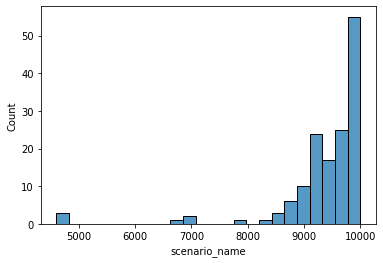

In [29]:
counts = joined_df["scenario_name"].value_counts()
sns.histplot(counts)

#### Manual train-test split across scenario boundaries

In [30]:
import random
unique_scenarios = list(joined_df["scenario_name"].unique())
unique_scenarios = sorted(unique_scenarios)
random.shuffle(unique_scenarios, random=lambda: 0.43)
train_scenarios = unique_scenarios[len(unique_scenarios)//3:]
test_scenarios = unique_scenarios[:len(unique_scenarios)//3]

train, train_labels = joined_df[joined_df["scenario_name"].isin(train_scenarios)], labels[joined_df["scenario_name"].isin(train_scenarios)]
test, test_labels = joined_df[joined_df["scenario_name"].isin(test_scenarios)], labels[joined_df["scenario_name"].isin(test_scenarios)]

In [31]:
train_scenarios

['training_0004-S3',
 'training_0000-S7',
 'training_0004-S7',
 'training_0000-S8',
 'training_0005-S10',
 'training_0000-S9',
 'training_0005-S15',
 'training_0005-S17',
 'training_0001-S0',
 'training_0005-S21',
 'training_0001-S1',
 'training_0005-S3',
 'training_0001-S10',
 'training_0005-S8',
 'training_0002-S23',
 'training_0001-S11',
 'training_0002-S3',
 'training_0001-S12',
 'training_0002-S5',
 'training_0001-S13',
 'training_0002-S7',
 'training_0002-S8',
 'training_0001-S14',
 'training_0003-S0',
 'training_0001-S15',
 'training_0003-S10',
 'training_0001-S16',
 'training_0003-S12',
 'training_0003-S13',
 'training_0001-S17',
 'training_0003-S15',
 'training_0001-S18',
 'training_0003-S17',
 'training_0001-S19',
 'training_0003-S19',
 'training_0003-S2',
 'training_0001-S2',
 'training_0003-S21',
 'training_0001-S20',
 'training_0003-S23',
 'training_0001-S21',
 'training_0003-S3',
 'training_0003-S4',
 'training_0001-S22',
 'training_0003-S6',
 'training_0001-S23',
 'train

In [32]:
train = train.drop(columns=["scenario_name"])
test = test.drop(columns=["scenario_name"])

#### Automated cross-validation splitter across scenario boundaries

In [33]:
# Features for feature importances
features = list(train.columns)
features, len(features)

(['D-conf',
  'T-min-iou',
  'T-max-age',
  'T-every-nth-det',
  'avg_bbox_longevity',
  '90p_bbox_longevity',
  '10p_bbox_longevity',
  'avg_num_bboxes',
  '90p_num_bboxes',
  '10p_num_bboxes',
  'avg_bbox_size',
  '90p_bbox_size',
  '10p_bbox_size',
  'avg_bbox_speed',
  '90p_bbox_speed',
  '10p_bbox_speed',
  'avg_ego_speed',
  '90p_ego_speed',
  '10p_ego_speed',
  'D-model__efficientdet-d1',
  'D-model__efficientdet-d2',
  'D-model__efficientdet-d3',
  'D-model__efficientdet-d4',
  'D-model__efficientdet-d5',
  'D-model__efficientdet-d6',
  'D-model__efficientdet-d7',
  'D-model__efficientdet-d7x',
  'D-seq-pol__eager',
  'D-seq-pol__tail-aware',
  'D-seq-pol__wait',
  'T-model__sort',
  'time_of_day__Dawn/Dusk',
  'time_of_day__Day',
  'time_of_day__Night',
  'location__location_other',
  'location__location_phx',
  'location__location_sf'],
 37)

### Do a bit of a cross-val hyperparameter search. This is very rudimentary.

In [34]:
# Create the model with 100 trees
model = RandomForestRegressor(n_estimators=1600, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [35]:
from scipy.stats import loguniform, randint

In [36]:
[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]

[5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01]

In [37]:
x = loguniform(0.00005, 0.05, scale=2).rvs(size=10000)

(array([6673., 1000.,  579.,  424.,  339.,  268.,  230.,  193.,  153.,
         141.]),
 array([0.00010004, 0.0100818 , 0.02006356, 0.03004532, 0.04002708,
        0.05000884, 0.0599906 , 0.06997236, 0.07995412, 0.08993588,
        0.09991764]),
 <BarContainer object of 10 artists>)

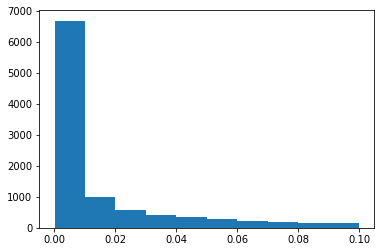

In [38]:
import matplotlib.pyplot as plt
plt.hist(x)

In [39]:
x = randint(3,10).rvs(size=10000)

In [40]:
import matplotlib.pyplot as plt
np.bincount(x)

array([   0,    0,    0, 1430, 1478, 1416, 1460, 1449, 1415, 1352])

In [41]:
# 7:32am start

In [42]:
from ad_config_search.rforest_utils import ScenarioAwareCVSplitter

In [43]:
%%time
clf = RandomizedSearchCV(model, {
    "max_depth": randint(1, 25),
    "max_features": randint(2, 24),
    "n_estimators": [200, 400, 800, 1600, 2400],
    "min_impurity_decrease": loguniform(0.00005, 0.05, scale=2)
}, cv=ScenarioAwareCVSplitter(n_splits=5, shuffle=True, random_state=RSEED), n_iter=100)
clf.fit(train, train_labels)

<class 'pandas.core.frame.DataFrame'>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   51.3s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.3s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.8s
[Parallel(n_jobs=144)]: Done 1600 out of 1600 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elaps

CPU times: user 3h 44min 12s, sys: 17min 10s, total: 4h 1min 22s
Wall time: 4h 53min 21s


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   12.4s finished


RandomizedSearchCV(cv=<ad_config_search.rforest_utils.ScenarioAwareCVSplitter object at 0x7fc47595a9e8>,
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=1600, n_jobs=-1,
                                                   random_state=50, verbose=1),
                   n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc47595a4a8>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc47595a5f8>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc47595a748>,
                                        'n_estimators': [200, 400, 800, 1600,
                                                         2400]})

In [67]:
# per-scenario grained
clf.cv_results_

{'mean_fit_time': array([ 13.60228038,  12.93668113,  21.48796592,  98.98848577,
         34.54982977,   7.34225445,  89.2219131 ,   3.68464241,
         64.02153502,  18.71725492,  13.99185929,   2.66076665,
         11.28685107,  40.98371506,  71.46419921,  85.74601936,
         48.78321257,   3.51353326,  26.80216155,   5.647715  ,
         33.33482609, 112.43242307,   3.74420805,   7.63872447,
         20.99711604,   8.38579674,  95.16363378,  53.8401691 ,
         13.26439118,  12.71113253,  38.27607374,  20.10103354,
         71.81475191,   2.25435419,  13.90642419,   4.86666322,
         16.55850272,  29.0594656 ,   9.71992049,  47.0719624 ,
         43.0640213 ,  48.636937  ,  16.35087223,   4.86734571,
         23.72788291,  85.51852241,   3.94009571,  23.88549757,
          6.52997975,  32.61102004,  21.16809111,  43.69443011,
         30.87174487,   8.08460059,  30.54601126,  39.0603941 ,
          8.08694005,  12.38469634,   8.98359962,  14.83995461,
         17.73350487,  

In [68]:
# per-scenario grained
clf.best_estimator_

RandomForestRegressor(max_depth=22, max_features=3,
                      min_impurity_decrease=0.00020630406970744498,
                      n_estimators=400, n_jobs=-1, random_state=50, verbose=1)

## Training

In [69]:
# Create the model with 100 trees
model = RandomForestRegressor(
max_depth=22, max_features=3,
                      min_impurity_decrease=0.00020630406970744498,
                      n_estimators=400,
    random_state=RSEED, 
#                               max_features = 'sqrt',
                              n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   13.3s finished


RandomForestRegressor(max_depth=22, max_features=3,
                      min_impurity_decrease=0.00020630406970744498,
                      n_estimators=400, n_jobs=-1, random_state=50, verbose=1)

In [70]:
sorted(zip(features, model.feature_importances_), key=(lambda f: f[1]), reverse=True)

[('avg_ego_speed', 0.08989833412757382),
 ('90p_ego_speed', 0.08752906198333461),
 ('10p_ego_speed', 0.0853745814201667),
 ('90p_bbox_size', 0.05924558360526142),
 ('avg_bbox_size', 0.05895139057409128),
 ('10p_bbox_size', 0.05886101829206477),
 ('avg_num_bboxes', 0.04848759276241036),
 ('location__location_other', 0.04482419055161405),
 ('10p_bbox_speed', 0.0444110904954417),
 ('avg_bbox_speed', 0.043061183225135205),
 ('90p_bbox_speed', 0.04200334311824426),
 ('90p_num_bboxes', 0.03412238340588819),
 ('10p_num_bboxes', 0.0307827435594374),
 ('90p_bbox_longevity', 0.03075181688945523),
 ('avg_bbox_longevity', 0.029724947652005885),
 ('location__location_sf', 0.02537792066200684),
 ('T-max-age', 0.016547044772792736),
 ('location__location_phx', 0.01612024351671874),
 ('10p_bbox_longevity', 0.015608259795287042),
 ('D-model__efficientdet-d7x', 0.014417292353086168),
 ('T-every-nth-det', 0.014060539286897038),
 ('D-model__efficientdet-d2', 0.012290408287680436),
 ('time_of_day__Day', 0.

In [71]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 32026
Average maximum depth 22


In [72]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_score = model.score(train, train_labels)
print("train score", train_score)

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
test_score = model.score(test, test_labels)
print("test score", test_score)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    1.3s finished


train score 0.9388166248414801


[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.


test score 0.11951607726307734


[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    0.7s finished


In [73]:
model_type = "RF"
env_window = "40"
time = "1-step-past"
env_feats = "pipeline-output-v1"
dictionary = {
    "model": model,
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "test_labels": test_labels,
    "metadata": "condensed config space"
}
with open("model={}__env-window={}__time={}__env-feats={}__te={:.2f}.pl".format(model_type, env_window, time, env_feats, test_score), 'wb') as f:
    pickle.dump(dictionary, f)

## Using trained model to get best config and saving

In [74]:
train_copy = train.copy()
train_copy["ground_truth"] = train_labels
test_copy = test.copy()
test_copy["ground_truth"] = test_labels

In [75]:
train_copy["prediction"] = model.predict(train)
test_copy["prediction"] = model.predict(test)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    1.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    0.7s finished


In [76]:
train.index.unique()

Index(['training_0000-S7-P1_5', 'training_0000-S7-P2_5',
       'training_0000-S7-P3_5', 'training_0000-S7-P4_5',
       'training_0000-S8-P1_5', 'training_0000-S8-P2_5',
       'training_0000-S8-P3_5', 'training_0000-S8-P4_5',
       'training_0000-S9-P1_5', 'training_0000-S9-P2_5',
       ...
       'training_0005-S7-P3_5', 'training_0005-S7-P4_5',
       'training_0005-S8-P1_5', 'training_0005-S8-P2_5',
       'training_0005-S8-P3_5', 'training_0005-S8-P4_5',
       'training_0005-S9-P1_5', 'training_0005-S9-P2_5',
       'training_0005-S9-P3_5', 'training_0005-S9-P4_5'],
      dtype='object', length=387)

In [77]:
test.index.unique()

Index(['training_0000-S0-P1_5', 'training_0000-S0-P2_5',
       'training_0000-S0-P3_5', 'training_0000-S0-P4_5',
       'training_0000-S1-P1_5', 'training_0000-S1-P2_5',
       'training_0000-S1-P3_5', 'training_0000-S1-P4_5',
       'training_0000-S10-P1_5', 'training_0000-S10-P2_5',
       ...
       'training_0005-S19-P3_5', 'training_0005-S19-P4_5',
       'training_0005-S23-P1_5', 'training_0005-S23-P2_5',
       'training_0005-S23-P3_5', 'training_0005-S23-P4_5',
       'training_0005-S6-P1_5', 'training_0005-S6-P2_5',
       'training_0005-S6-P3_5', 'training_0005-S6-P4_5'],
      dtype='object', length=196)

In [78]:
train_copy["run_name"] = train_copy.index
test_copy["run_name"] = test_copy.index

In [79]:
to_predict = test_copy

In [80]:
best_predicted_configs = pd.DataFrame([rows.iloc[rows["prediction"].argmax()] for run_name, rows in to_predict.groupby(["run_name"])])

In [81]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,...,pastC-D-model__efficientdet-d6,pastC-D-model__efficientdet-d7,pastC-D-model__efficientdet-d7x,pastC-D-seq-pol__eager,pastC-D-seq-pol__infinite,pastC-D-seq-pol__tail-aware,pastC-D-seq-pol__wait,ground_truth,prediction,run_name
training_0000-S0-P1_5,0.3,0.1,1,1,20.250000,31.5,9.6,2.025,3.0,0.9,...,0,0,0,1,0,0,0,40.555556,58.102445,training_0000-S0-P1_5
training_0000-S0-P2_5,0.5,0.2,3,1,28.000000,40.0,11.1,5.600,6.0,5.0,...,0,0,0,0,0,1,0,46.641075,50.849488,training_0000-S0-P2_5
training_0000-S0-P3_5,0.3,0.2,5,1,20.333333,40.0,5.0,6.100,7.0,5.0,...,0,0,0,0,0,1,0,58.150852,51.422571,training_0000-S0-P3_5
training_0000-S0-P4_5,0.3,0.1,3,1,19.625000,33.0,10.5,3.925,5.0,3.0,...,0,0,0,0,0,1,0,68.900804,53.832809,training_0000-S0-P4_5
training_0000-S1-P1_5,0.3,0.2,3,1,9.681818,20.7,3.0,5.325,7.0,3.6,...,0,0,0,0,0,1,0,21.558442,39.125896,training_0000-S1-P1_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S23-P4_5,0.3,0.1,5,1,34.000000,40.0,26.0,3.400,4.0,2.0,...,0,0,1,1,0,0,0,75.000000,38.425636,training_0005-S23-P4_5
training_0005-S6-P1_5,0.3,0.2,5,1,14.888889,30.4,3.0,3.350,5.0,1.8,...,0,1,0,0,0,0,1,15.147265,22.782569,training_0005-S6-P1_5
training_0005-S6-P2_5,0.3,0.2,5,1,13.142857,28.0,2.0,6.900,8.0,6.0,...,0,1,0,0,0,1,0,14.735658,23.814850,training_0005-S6-P2_5
training_0005-S6-P3_5,0.3,0.2,5,1,16.769231,37.8,4.0,5.450,6.0,5.0,...,0,1,0,1,0,0,0,25.144509,25.629115,training_0005-S6-P3_5


In [82]:
parent_columns = set([c.split("__")[0] for c in best_predicted_configs.columns if "__" in c])
for pc in parent_columns:
    ccs = list(filter(lambda cc: cc.startswith(pc), best_predicted_configs.columns))
    rows = best_predicted_configs[ccs]
    rows.columns = [cc.split("__")[1] for cc in ccs]
    best_predicted_configs[pc] = rows.idxmax(axis=1)
    best_predicted_configs = best_predicted_configs.drop(columns=ccs)

In [83]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,...,ground_truth,prediction,run_name,T-model,pastC-D-seq-pol,D-model,time_of_day,D-seq-pol,location,pastC-D-model
training_0000-S0-P1_5,0.3,0.1,1,1,20.250000,31.5,9.6,2.025,3.0,0.9,...,40.555556,58.102445,training_0000-S0-P1_5,sort,eager,efficientdet-d6,Day,eager,location_sf,efficientdet-d2
training_0000-S0-P2_5,0.5,0.2,3,1,28.000000,40.0,11.1,5.600,6.0,5.0,...,46.641075,50.849488,training_0000-S0-P2_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3
training_0000-S0-P3_5,0.3,0.2,5,1,20.333333,40.0,5.0,6.100,7.0,5.0,...,58.150852,51.422571,training_0000-S0-P3_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3
training_0000-S0-P4_5,0.3,0.1,3,1,19.625000,33.0,10.5,3.925,5.0,3.0,...,68.900804,53.832809,training_0000-S0-P4_5,sort,tail-aware,efficientdet-d5,Day,wait,location_sf,efficientdet-d1
training_0000-S1-P1_5,0.3,0.2,3,1,9.681818,20.7,3.0,5.325,7.0,3.6,...,21.558442,39.125896,training_0000-S1-P1_5,sort,tail-aware,efficientdet-d5,Day,tail-aware,location_sf,efficientdet-d1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S23-P4_5,0.3,0.1,5,1,34.000000,40.0,26.0,3.400,4.0,2.0,...,75.000000,38.425636,training_0005-S23-P4_5,sort,eager,efficientdet-d4,Day,tail-aware,location_phx,efficientdet-d7x
training_0005-S6-P1_5,0.3,0.2,5,1,14.888889,30.4,3.0,3.350,5.0,1.8,...,15.147265,22.782569,training_0005-S6-P1_5,sort,wait,efficientdet-d4,Night,wait,location_phx,efficientdet-d7
training_0005-S6-P2_5,0.3,0.2,5,1,13.142857,28.0,2.0,6.900,8.0,6.0,...,14.735658,23.814850,training_0005-S6-P2_5,sort,tail-aware,efficientdet-d4,Night,wait,location_phx,efficientdet-d7
training_0005-S6-P3_5,0.3,0.2,5,1,16.769231,37.8,4.0,5.450,6.0,5.0,...,25.144509,25.629115,training_0005-S6-P3_5,sort,eager,efficientdet-d4,Night,wait,location_phx,efficientdet-d7


In [84]:
best_predicted_configs["scenario_name"] = best_predicted_configs.index.map(lambda x: "-".join(x.split("-")[:2]))

In [85]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,...,prediction,run_name,T-model,pastC-D-seq-pol,D-model,time_of_day,D-seq-pol,location,pastC-D-model,scenario_name
training_0000-S0-P1_5,0.3,0.1,1,1,20.250000,31.5,9.6,2.025,3.0,0.9,...,58.102445,training_0000-S0-P1_5,sort,eager,efficientdet-d6,Day,eager,location_sf,efficientdet-d2,training_0000-S0
training_0000-S0-P2_5,0.5,0.2,3,1,28.000000,40.0,11.1,5.600,6.0,5.0,...,50.849488,training_0000-S0-P2_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3,training_0000-S0
training_0000-S0-P3_5,0.3,0.2,5,1,20.333333,40.0,5.0,6.100,7.0,5.0,...,51.422571,training_0000-S0-P3_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3,training_0000-S0
training_0000-S0-P4_5,0.3,0.1,3,1,19.625000,33.0,10.5,3.925,5.0,3.0,...,53.832809,training_0000-S0-P4_5,sort,tail-aware,efficientdet-d5,Day,wait,location_sf,efficientdet-d1,training_0000-S0
training_0000-S1-P1_5,0.3,0.2,3,1,9.681818,20.7,3.0,5.325,7.0,3.6,...,39.125896,training_0000-S1-P1_5,sort,tail-aware,efficientdet-d5,Day,tail-aware,location_sf,efficientdet-d1,training_0000-S1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S23-P4_5,0.3,0.1,5,1,34.000000,40.0,26.0,3.400,4.0,2.0,...,38.425636,training_0005-S23-P4_5,sort,eager,efficientdet-d4,Day,tail-aware,location_phx,efficientdet-d7x,training_0005-S23
training_0005-S6-P1_5,0.3,0.2,5,1,14.888889,30.4,3.0,3.350,5.0,1.8,...,22.782569,training_0005-S6-P1_5,sort,wait,efficientdet-d4,Night,wait,location_phx,efficientdet-d7,training_0005-S6
training_0005-S6-P2_5,0.3,0.2,5,1,13.142857,28.0,2.0,6.900,8.0,6.0,...,23.814850,training_0005-S6-P2_5,sort,tail-aware,efficientdet-d4,Night,wait,location_phx,efficientdet-d7,training_0005-S6
training_0005-S6-P3_5,0.3,0.2,5,1,16.769231,37.8,4.0,5.450,6.0,5.0,...,25.629115,training_0005-S6-P3_5,sort,eager,efficientdet-d4,Night,wait,location_phx,efficientdet-d7,training_0005-S6


In [86]:
RF_policy_scores = {}
for scenario_name, rows in best_predicted_configs.groupby(["scenario_name"]):
    RF_policy_scores[scenario_name] = rows["ground_truth"].mean()

In [87]:
RF_policy_scores

{'training_0000-S0': 53.56207157066359,
 'training_0000-S1': 29.948835878391762,
 'training_0000-S10': 35.79411075986418,
 'training_0000-S11': 23.07388894421296,
 'training_0000-S12': 2.4097171341010393,
 'training_0000-S13': 81.77207159724884,
 'training_0000-S14': 52.94705335435526,
 'training_0000-S15': 23.39544971775312,
 'training_0000-S16': 37.27740570765854,
 'training_0000-S17': 26.318646778411985,
 'training_0000-S18': 28.231807802980647,
 'training_0000-S19': 78.34778215396193,
 'training_0000-S2': 33.38901144787252,
 'training_0000-S20': 66.08451729997026,
 'training_0000-S21': 35.46017072042024,
 'training_0000-S22': 22.309146975629233,
 'training_0000-S23': 32.71050788804841,
 'training_0000-S3': 71.22767857142858,
 'training_0000-S4': 20.47957254154688,
 'training_0000-S5': 45.037907591714145,
 'training_0000-S6': 44.48423403753629,
 'training_0002-S24': 20.84790703659288,
 'training_0002-S4': 28.82850241545894,
 'training_0002-S6': -12.919353331464345,
 'training_0002-S

In [88]:
RF_policy_map = {}
for index, row in best_predicted_configs.iterrows():
    config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"]
    RF_policy_map[index] = {c: row[c] for c in config_columns}

In [89]:
RF_policy_map

{'training_0000-S0-P1_5': {'D-model': 'efficientdet-d6',
  'D-conf': 0.3,
  'D-seq-pol': 'eager',
  'T-min-iou': 0.1,
  'T-max-age': 1,
  'T-every-nth-det': 1},
 'training_0000-S0-P2_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.5,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.2,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S0-P3_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.2,
  'T-max-age': 5,
  'T-every-nth-det': 1},
 'training_0000-S0-P4_5': {'D-model': 'efficientdet-d5',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.1,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S1-P1_5': {'D-model': 'efficientdet-d5',
  'D-conf': 0.3,
  'D-seq-pol': 'tail-aware',
  'T-min-iou': 0.2,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S1-P2_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.5,
  'D-seq-pol': 'tail-aware',
  'T-min-iou': 0.1,
  'T-max-age': 1,
  'T-every-nth-det': 1},
 'training_0000-S1-P3_5': {

In [90]:
import pickle
with open("RF_test_4s_grain_condensed_pipeline_output_past_policy_map.pl", 'wb') as f:
    pickle.dump(RF_policy_map, f)

In [91]:
import pickle
with open("RF_test_4s_grain_condensed_pipeline_output_past_policy_scores.pl", 'wb') as f:
    pickle.dump(RF_policy_scores, f)